In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
from reservoirpy.observables import nrmse, rsquare

import reservoirpy as rpy

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import mackey_glass

import reservoirpy as rpy

rpy.verbosity(0)  # no need to be too verbose here
rpy.set_seed(42)  # make everyhting reproducible !

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from scipy.integrate import solve_ivp

def coupled_system(t, state, mu, sigma, rho, beta):
    X, Y, x_lorenz, y_lorenz, z_lorenz = state
    
    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X + x_lorenz
    
    dx_lorenz_dt = sigma * (y_lorenz - x_lorenz)
    dy_lorenz_dt = x_lorenz * (rho - z_lorenz) - y_lorenz
    dz_lorenz_dt = x_lorenz * y_lorenz - beta * z_lorenz
    
    return [dXdt, dYdt, dx_lorenz_dt, dy_lorenz_dt, dz_lorenz_dt]

mu = 1.0
sigma = 10.0
rho = 28.0
beta = 8/3
initial_state = [1.0, 0.0, 1.0, 1.0, 1.0]  # Initial states for [X, Y, x_lorenz, y_lorenz, z_lorenz]
t_span = (0, 2510)

sol = solve_ivp(coupled_system, t_span, initial_state, args=(mu, sigma, rho, beta), t_eval=np.linspace(t_span[0], t_span[1], 25100), max_step = 0.01)

In [3]:
data_loaded = pd.read_csv('coupled_system_dataset.csv')

In [4]:
#Time, Van Der Pol　OscillatorのX, lorenzのx項のみを抽出、学習。

data = pd.DataFrame({
    'X': sol.y[0],
    'Y': sol.y[1],
    'x_lorenz': sol.y[2],
    'y_lorenz': sol.y[3],
    'z_lorenz': sol.y[4]
})

# DataFrameをCSVファイルに保存
data.to_csv('coupled_system_dataset.csv', index=False)

In [5]:
X = data.values

In [6]:
X.shape

(25100, 5)

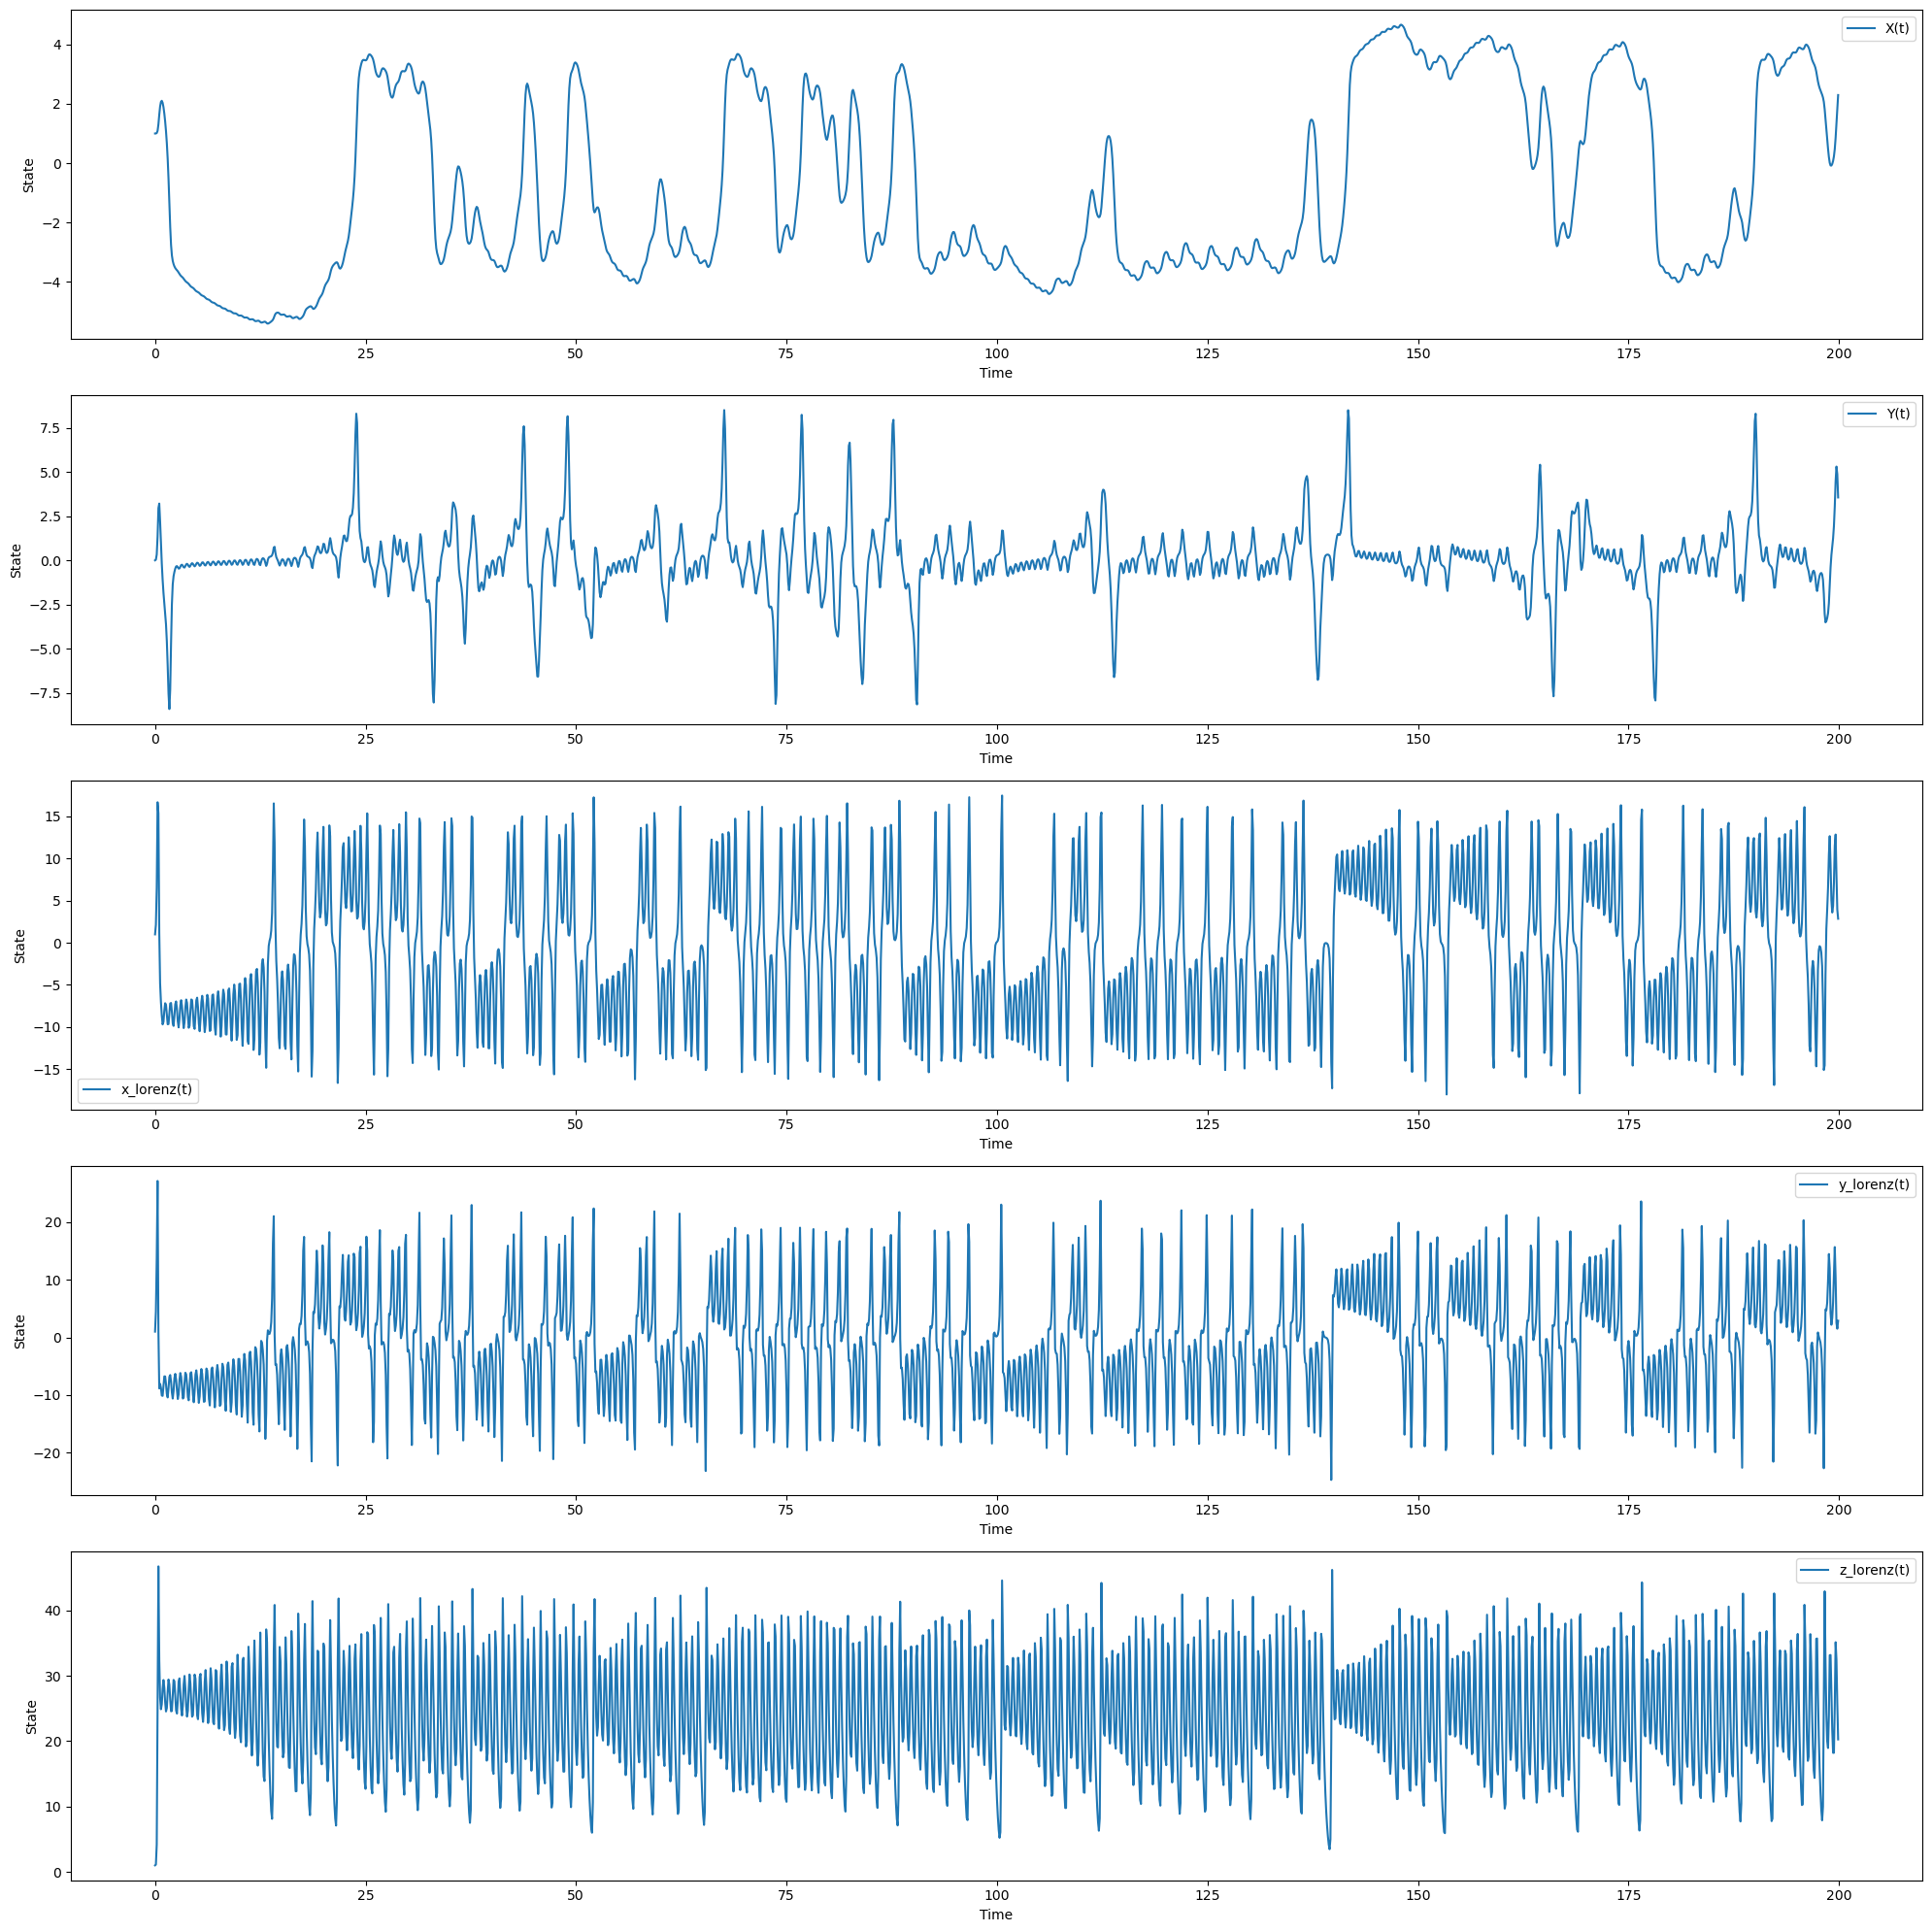

In [7]:
# Plot the results
sample = 2000

plt.figure(figsize=(20, 20))

plt.subplot(5, 1, 1)
plt.plot(sol.t[:sample], sol.y[0][:sample], label='X(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(sol.t[:sample], sol.y[1][:sample], label='Y(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(sol.t[:sample], sol.y[2][:sample], label='x_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(sol.t[:sample], sol.y[3][:sample], label='y_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(sol.t[:sample], sol.y[4][:sample], label='z_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    N_value = int(N)  # Nを整数に変換    
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N_value, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        prediction = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test[:, :2], prediction[:, :2], norm_value=np.ptp(X_train))
        r2 = rsquare(y_test[:, :2], prediction[:, :2])
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [9]:
hyperopt_config = {
    "exp": f"hyperopt-multiscroll", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["quniform", 500, 5000, 1],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

In [10]:
from reservoirpy.datasets import to_forecasting

train_len = 10000
test_len = 10000

x, y = to_forecasting(X, forecast=1)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+test_len], y[train_len:train_len+test_len]

dataset = ((X_train, y_train), (X_test, y_test))

In [11]:
from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

  0%|          | 0/200 [02:31<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [ ]:
best

({'N': 3849.0,
  'iss': 0.14258024657972923,
  'lr': 0.5516837456874331,
  'ridge': 3.7433235003717447e-07,
  'seed': 0,
  'sr': 0.1931498404234262},
 <hyperopt.base.Trials at 0x17e29a310>)

In [12]:
# bestから取得したハイパーパラメータを設定
N = 3849
iss =  0.14258024657972923
lr = 0.5516837456874331
ridge = 3.7433235003717447e-07
seed = 1234
sr =  0.1931498404234262

In [13]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout

In [14]:
# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
esn_model = reservoir >> readout

# モデルの訓練と予測
predictions = esn_model.fit(X_train, y_train).run(X_test)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_test, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 8.473885849045176e-05
R^2: 0.999999722975628


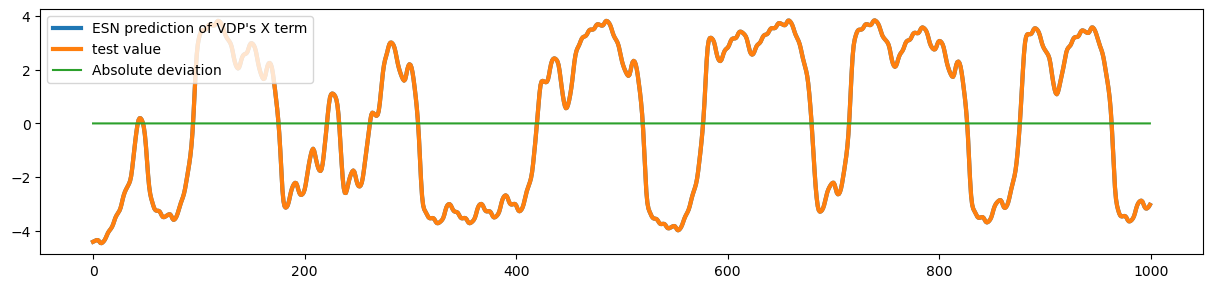

In [15]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, :1][:sample], lw=3, label="ESN prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, :1][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, :1][:sample] - predictions[:, :1][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

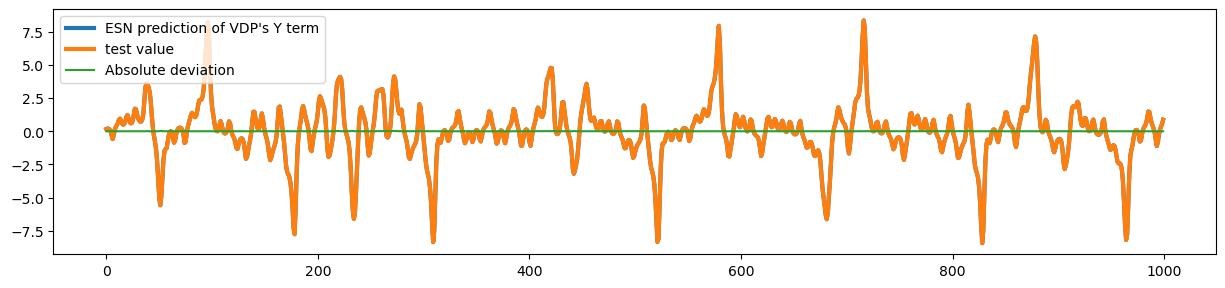

In [16]:
sample = 1000

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 1:2][:sample], lw=3, label="ESN prediction of VDP's Y term")
plt.plot(np.arange(sample), y_test[:, 1:2][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 1:2][:sample] - predictions[:, 1:2][:sample]), label="Absolute deviation")

plt.legend()
plt.show()

In [17]:
rsquare(y_test, predictions), nrmse(y_test, predictions)

(0.999999722975628, 8.678305379228906e-05)

### Generative Modelを使ってみる

考えることは以下の通り

1. Generative modelを更新するごとに、外力に関しては実データを用いる。
2. 一周期$2\pi$で約1日に相当する。最終的には14日程度の予測を行えるようにしたいので、約100程度の予測が出来れば十分である。
3. 今，データは0.1刻みで出力しているので，1000程度の長さの間予測が上手くいってそうであれば良い．

In [18]:
def plot_generation(X_gen, X_t, nb_generations, warming_out=None, warming_inputs=None, seed_timesteps=0):

    plt.figure(figsize=(15, 5))
    if warming_out is not None:
        plt.plot(np.vstack([warming_out, X_gen]), label="Generated timeseries")
    else:
        plt.plot(X_gen, label="Generated timeseries")

    plt.plot(np.arange(nb_generations)+seed_timesteps, X_t, linestyle="--", label="Real timeseries")

    if warming_inputs is not None:
        plt.plot(np.arange(seed_timesteps), warming_inputs, linestyle="--", label="Warmup")

    plt.plot(np.arange(nb_generations)+seed_timesteps, np.abs(X_t - X_gen),
             label="Absolute deviation")

    if seed_timesteps > 0:
        plt.fill_between([0, seed_timesteps], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warmup")

    plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_t, X_gen), 4)}$")
    plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_t, X_gen), 4)}$")
    plt.legend(
    )
    plt.show()